<a href="https://colab.research.google.com/github/shakyaanice/basics-of-gee/blob/master/GEE_Python_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-testgee')


In [2]:
city='Kathmandu'
population =300000
print(city, population)

Kathmandu 300000


In [3]:
s2=ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
geometry= ee.Geometry.Polygon([[ [82.60642647743225, 27.16350437805251],
  [82.60984897613525, 27.1618529901377],
  [82.61088967323303, 27.163695288375266],
  [82.60757446289062, 27.16517483230927]]])

In [4]:
filtered =s2\
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2019-02-01','2019-03-01'))\
.filter(ee.Filter.bounds(geometry))
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])


In [5]:
def ndvi(image):
  ndvi=image.normalizedDifference(['B8','B4']).rename('ndvi')
  return image.addBands(ndvi)

withNDVI = filtered\
.map(maskS2clouds).map(ndvi)


In [6]:
composite = withNDVI.median()
ndvi = composite.select('ndvi')

stats = ndvi.reduceRegion(**{
  'reducer': ee.Reducer.mean(),
  'geometry': geometry,
  'scale': 10,
  'maxPixels': 1e10
  })

In [7]:
print(stats.get('ndvi').getInfo())


0.6795091979989383


In [8]:
myList =ee.List.sequence(1,10)
newList =myList.map(lambda number: ee.Number(number).pow(2))
print(newList.getInfo())

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


In [9]:
geometry= ee.Geometry.Point([77.60412933051538, 12.952912912328241])
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
filtered = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
  .filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
  .filter(ee.Filter.bounds(geometry))

size= filtered.size().getInfo()
print(size)

30


In [10]:
import geemap


In [11]:
Map= geemap.Map(width=800)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [12]:
geometry = ee.Geometry.Point([77.60412933051538, 12.952912912328241])
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

rgbVis = {'min': 0.0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

filtered = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01')) \
  .filter(ee.Filter.bounds(geometry))

medianComposite = filtered.median()

Map.centerObject(geometry, 10)
Map.addLayer(medianComposite, rgbVis, 'Median Composite')

In [13]:
javascript_code = """
var geometry = ee.Geometry.Point([107.61303468448624, 12.130969369851766]);
Map.centerObject(geometry, 12)
var s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
var rgbVis = {
  min: 0.0,
  max: 3000,
  bands: ['B4', 'B3', 'B2'],
};

var filtered = s2
  .filter(ee.Filter.date('2019-01-01', '2020-01-01'))
  .filter(ee.Filter.bounds(geometry))

// Load the Cloud Score+ collection
var csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED');
var csPlusBands = csPlus.first().bandNames();

// We need to add Cloud Score + bands to each Sentinel-2
// image in the collection
// This is done using the linkCollection() function
var filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands);

// Function to mask pixels with low CS+ QA scores.
function maskLowQA(image) {
  var qaBand = 'cs';
  var clearThreshold = 0.5;
  var mask = image.select(qaBand).gte(clearThreshold);
  return image.updateMask(mask);
}


var filteredMasked = filteredS2WithCs
  .map(maskLowQA);

// Write a function that computes NDVI for an image and adds it as a band
function addNDVI(image) {
  var ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi');
  return image.addBands(ndvi);
}

var withNdvi = filteredMasked.map(addNDVI);

var composite = withNdvi.median()
palette = [
  'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301'];

ndviVis = {min:0, max:0.7, palette: palette }
Map.addLayer(withNdvi.select('ndvi'), ndviVis, 'NDVI Composite')

"""
lines = geemap.js_snippet_to_py(
    javascript_code, add_new_cell=False,
    import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap

m = geemap.Map()

geometry = ee.Geometry.Point([107.61303468448624, 12.130969369851766])
m.centerObject(geometry, 12)
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
rgbVis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01')) \
  .filter(ee.Filter.bounds(geometry))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
  qaBand = 'cs'
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
  .map(maskLowQA)

# Write a function that 

In [14]:
m = geemap.Map()

geometry = ee.Geometry.Point([107.61303468448624, 12.130969369851766])
m.centerObject(geometry, 12)
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
rgbVis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01')) \
  .filter(ee.Filter.bounds(geometry))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
  qaBand = 'cs'
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
.map(maskLowQA)

# Write a function that computes NDVI for an image and adds it as a band
def addNDVI(image):
  ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

withNdvi = filteredMasked.map(addNDVI)

composite = withNdvi.median()
palette = [
  'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']

ndviVis = {'min':0, 'max':0.7, 'palette': palette }
m.addLayer(withNdvi.select('ndvi'), ndviVis, 'NDVI Composite')

m

Map(center=[12.130969369851766, 107.61303468448625], controls=(WidgetControl(options=['position', 'transparent…

In [15]:
javascript = '''
var admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2");

var karnataka = admin2.filter(ee.Filter.eq('ADM1_NAME', 'Karnataka'))

var visParams = {color: 'red'}
Map.centerObject(karnataka)
Map.addLayer(karnataka, visParams, 'Karnataka Districts')

'''
lines = geemap.js_snippet_to_py(
    javascript, add_new_cell=False,
    import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())


import ee
import geemap

m = geemap.Map()

admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

karnataka = admin2.filter(ee.Filter.eq('ADM1_NAME', 'Karnataka'))

visParams = {'color': 'red'}
m.centerObject(karnataka)
m.addLayer(karnataka, visParams, 'Karnataka Districts')

m


In [16]:
m = geemap.Map()

admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

karnataka = admin2.filter(ee.Filter.eq('ADM1_NAME', 'Karnataka'))

visParams = {'color': 'red'}
m.centerObject(karnataka)
m.addLayer(karnataka, visParams, 'Karnataka Districts')

m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [17]:
geometry = ee.Geometry.Point([107.61303468448624, 12.130969369851766])
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
rgbVis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2019-01-31')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.bounds(geometry)) \

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
  qaBand = 'cs'
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
  .map(maskLowQA)

# Write a function that computes NDVI for an image and adds it as a band
def addNDVI(image):
  ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

withNdvi = filteredMasked.map(addNDVI)

In [18]:
#Export all images
image_ids = withNdvi.aggregate_array('system:index').getInfo()
print('Total images: ', len(image_ids))

Total images:  2


In [19]:
# Export with 100m resolution for this demo
for i, image_id in enumerate(image_ids):
  image = ee.Image(withNdvi.filter(ee.Filter.eq('system:index', image_id)).first())
  task = ee.batch.Export.image.toDrive(**{
    'image': image.select('ndvi'),
    'description': 'Image Export {}'.format(i+1),
    'fileNamePrefix': image_id,
    'folder':'earthengine',
    'scale': 100,
    'region': image.geometry(),
    'maxPixels': 1e10
  })
  task.start()
  print('Started Task: ', i+1)

Started Task:  1
Started Task:  2


In [20]:

lsib = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
australia = lsib.filter(ee.Filter.eq('country_na', 'Australia'))
geometry = australia.geometry()

terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
tmax = terraclimate.select('tmmx')

def scale(image):
  return image.multiply(0.1) \
    .copyProperties(image,['system:time_start'])

tmaxScaled = tmax.map(scale)

filtered = tmaxScaled \
  .filter(ee.Filter.date('2020-01-01', '2020-03-01')) \
  .filter(ee.Filter.bounds(geometry))

image_ids = filtered.aggregate_array('system:index').getInfo()
print('Total images: ', len(image_ids))

Total images:  2


In [21]:
for i, image_id in enumerate(image_ids):
    exportImage = ee.Image(filtered.filter(ee.Filter.eq('system:index', image_id)).first())
    # Clip the image to the region geometry
    clippedImage = exportImage.clip(geometry)

    ## Create the export task using ee.batch.Export.image.toDrive()
    task = ee.batch.Export.image.toDrive(**{
    'image': image.select('tmmx'),
    'description': 'Image Export {}'.format(i+1),
    'fileNamePrefix': image_id,
    'folder':'earthengine',
    'scale': 100,
    'region': image.geometry(),
    'maxPixels': 1e10
  })
  ## Start the task
    task.start()
    print('Started Task: ', i+1)


Started Task:  1
Started Task:  2


In [22]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee
!pip install xarray[complete]
import ee
import xarray

import matplotlib.pyplot as plt


In [23]:
geometry = ee.Geometry.Point([82.60759592318209, 27.163481733946846])
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

filtered = s2 \
  .filter(ee.Filter.date('2017-01-01', '2018-01-01')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.bounds(geometry))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
  qaBand = 'cs'
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
  .map(maskLowQA)

# Write a function that computes NDVI for an image and adds it as a band
# Create a new image to overcome https://github.com/google/Xee/issues/88
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.multiply(0.0001).addBands(ndvi)\
    .copyProperties(image, ['system:time_start'])

# Map the function over the collection
withNdvi = filteredMasked.map(addNDVI)

In [36]:
#Load ImageCollection as XArray Dataset
ds = xarray.open_dataset(
    withNdvi,
    engine='ee',
    crs='EPSG:3857',
    scale=10,
    geometry=geometry,
    ee_mask_value=-9999,
)

ds

<xarray.Dataset>
Dimensions:  (time: 31, X: 1, Y: 1)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-14T05:13:36.911000 ... 2017-12-22T...
  * X        (X) float64 9.196e+06
  * Y        (Y) float64 3.144e+06
Data variables: (12/19)
    B1       (time, X, Y) float32 ...
    B2       (time, X, Y) float32 ...
    B3       (time, X, Y) float32 ...
    B4       (time, X, Y) float32 ...
    B5       (time, X, Y) float32 ...
    B6       (time, X, Y) float32 ...
    ...       ...
    QA10     (time, X, Y) float32 ...
    QA20     (time, X, Y) float32 ...
    QA60     (time, X, Y) float32 ...
    cs       (time, X, Y) float32 ...
    cs_cdf   (time, X, Y) float32 ...
    ndvi     (time, X, Y) float32 ...
Attributes: (12/18)
    date_range:             [1435017600000, 1647993600000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'radiance', 's...
    period:                 0
    product_tags:           ['msi', 'radiance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:3857

In [37]:
#time-series at a single pixel
ndvi_time_series = ds.ndvi
original_time_series = ndvi_time_series.compute()
original_time_series = original_time_series.squeeze()
original_time_series

<xarray.DataArray 'ndvi' (time: 31)>
array([0.5033776 , 0.63813955, 0.56427604, 0.74168795,        nan,
       0.14802729, 0.15883777, 0.13142857, 0.07724426, 0.0973635 ,
       0.08064516,        nan, 0.05203938, 0.10798947, 0.6990376 ,
       0.5386646 , 0.640806  ,        nan,        nan, 0.40108788,
       0.21703963, 0.19086178, 0.11948052, 0.11813843,        nan,
       0.11563367, 0.07257407, 0.12698856,        nan, 0.36240703,
       0.29904875], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-14T05:13:36.911000 ... 2017-12-22T...
    X        float64 9.196e+06
    Y        float64 3.144e+06
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:3857
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

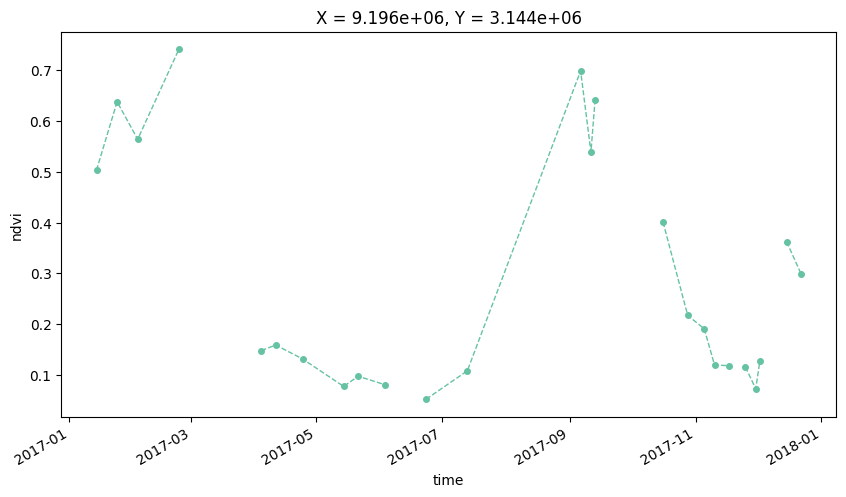

In [38]:
#Plot the time-series
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
original_time_series.plot.line(
    ax=ax, x='time',
    marker='o', color='#66c2a4', linestyle='--', linewidth=1, markersize=4)
plt.show()


In [40]:
#Process Time-Series using XArray by creating regularly spaced time series
time_series_resampled = original_time_series\
  .resample(time='5d').mean(dim='time')
time_series_resampled

<xarray.DataArray 'ndvi' (time: 69)>
array([0.5033776 ,        nan, 0.63813955,        nan, 0.56427604,
              nan,        nan,        nan, 0.74168795,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.14802729, 0.15883777,        nan,        nan,
       0.13142857,        nan,        nan,        nan, 0.07724426,
       0.0973635 ,        nan,        nan, 0.08064516,        nan,
              nan,        nan, 0.05203938,        nan,        nan,
              nan, 0.10798947,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.6990376 , 0.58973527,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.40108788,        nan, 0.21703963,        nan, 0.19086178,
       0.11948052, 0.11813843,        nan, 0.11563367, 0.09978132,
              nan,        nan, 0.36240703, 0.29904875], dtype=float32)
Coordinates:
    X        float64 9.196e+06
    Y        float64 3.144e+06
  * time     (time) datetime64[ns] 2017-01-14 2017-01-19 ... 2017-12-20
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:3857
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

In [41]:
#Fill the cloud-masked pixels with linearly interpolated values from temporal neighbors.
time_series_interpolated = time_series_resampled\
  .interpolate_na('time', use_coordinate=False)
time_series_interpolated

<xarray.DataArray 'ndvi' (time: 69)>
array([0.5033776 , 0.5707586 , 0.63813955, 0.6012078 , 0.56427604,
       0.608629  , 0.652982  , 0.697335  , 0.74168795, 0.66748035,
       0.5932728 , 0.5190652 , 0.44485763, 0.37065002, 0.29644245,
       0.22223487, 0.14802729, 0.15883777, 0.14970137, 0.14056496,
       0.13142857, 0.11788249, 0.10433641, 0.09079034, 0.07724426,
       0.0973635 , 0.09179072, 0.08621794, 0.08064516, 0.07349371,
       0.06634227, 0.05919082, 0.05203938, 0.0660269 , 0.08001442,
       0.09400195, 0.10798947, 0.16172111, 0.21545276, 0.2691844 ,
       0.32291606, 0.3766477 , 0.43037936, 0.484111  , 0.5378427 ,
       0.5915743 , 0.645306  , 0.6990376 , 0.58973527, 0.5627856 ,
       0.53583604, 0.5088864 , 0.48193675, 0.45498714, 0.4280375 ,
       0.40108788, 0.30906376, 0.21703963, 0.2039507 , 0.19086178,
       0.11948052, 0.11813843, 0.11688605, 0.11563367, 0.09978132,
       0.18732323, 0.27486512, 0.36240703, 0.29904875], dtype=float32)
Coordinates:
    X        float64 9.196e+06
    Y        float64 3.144e+06
  * time     (time) datetime64[ns] 2017-01-14 2017-01-19 ... 2017-12-20
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:3857
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

In [42]:
#apply a moving-window smoothing to remove noise.

time_series_smooth = time_series_interpolated\
  .rolling(time=3, center=True).mean()
time_series_smooth

<xarray.DataArray 'ndvi' (time: 69)>
array([       nan, 0.5707586 , 0.60336864, 0.60120785, 0.591371  ,
       0.6086291 , 0.6529821 , 0.6973351 , 0.70216787, 0.66748047,
       0.5932729 , 0.5190653 , 0.44485772, 0.37065014, 0.29644257,
       0.22223496, 0.17636673, 0.1521889 , 0.14970146, 0.14056507,
       0.12995878, 0.11788259, 0.10433652, 0.09079044, 0.08846613,
       0.08879959, 0.09179082, 0.08621804, 0.08011904, 0.07349381,
       0.06634237, 0.05919092, 0.0590858 , 0.066027  , 0.08001452,
       0.09400204, 0.1212376 , 0.1617212 , 0.21545285, 0.26918453,
       0.32291615, 0.3766478 , 0.43037945, 0.48411107, 0.53784275,
       0.5915744 , 0.645306  , 0.644693  , 0.6171862 , 0.5627857 ,
       0.5358361 , 0.50888646, 0.48193678, 0.45498714, 0.4280375 ,
       0.37939638, 0.30906373, 0.24335134, 0.20395069, 0.17143099,
       0.1428269 , 0.11816832, 0.11688603, 0.110767  , 0.13424605,
       0.18732321, 0.27486512, 0.31210697,        nan], dtype=float32)
Coordinates:
    X        float64 9.196e+06
    Y        float64 3.144e+06
  * time     (time) datetime64[ns] 2017-01-14 2017-01-19 ... 2017-12-20
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:3857
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

In [43]:
#A moving-window smoothing removed the first and last values of the time-series.
#We anchor the smoothed time-series with the values from the original time-series.
time_series_smooth[0] = original_time_series[0]
time_series_smooth[-1] = original_time_series[-1]
time_series_smooth

<xarray.DataArray 'ndvi' (time: 69)>
array([0.5033776 , 0.5707586 , 0.60336864, 0.60120785, 0.591371  ,
       0.6086291 , 0.6529821 , 0.6973351 , 0.70216787, 0.66748047,
       0.5932729 , 0.5190653 , 0.44485772, 0.37065014, 0.29644257,
       0.22223496, 0.17636673, 0.1521889 , 0.14970146, 0.14056507,
       0.12995878, 0.11788259, 0.10433652, 0.09079044, 0.08846613,
       0.08879959, 0.09179082, 0.08621804, 0.08011904, 0.07349381,
       0.06634237, 0.05919092, 0.0590858 , 0.066027  , 0.08001452,
       0.09400204, 0.1212376 , 0.1617212 , 0.21545285, 0.26918453,
       0.32291615, 0.3766478 , 0.43037945, 0.48411107, 0.53784275,
       0.5915744 , 0.645306  , 0.644693  , 0.6171862 , 0.5627857 ,
       0.5358361 , 0.50888646, 0.48193678, 0.45498714, 0.4280375 ,
       0.37939638, 0.30906373, 0.24335134, 0.20395069, 0.17143099,
       0.1428269 , 0.11816832, 0.11688603, 0.110767  , 0.13424605,
       0.18732321, 0.27486512, 0.31210697, 0.29904875], dtype=float32)
Coordinates:
    X        float64 9.196e+06
    Y        float64 3.144e+06
  * time     (time) datetime64[ns] 2017-01-14 2017-01-19 ... 2017-12-20
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:3857
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

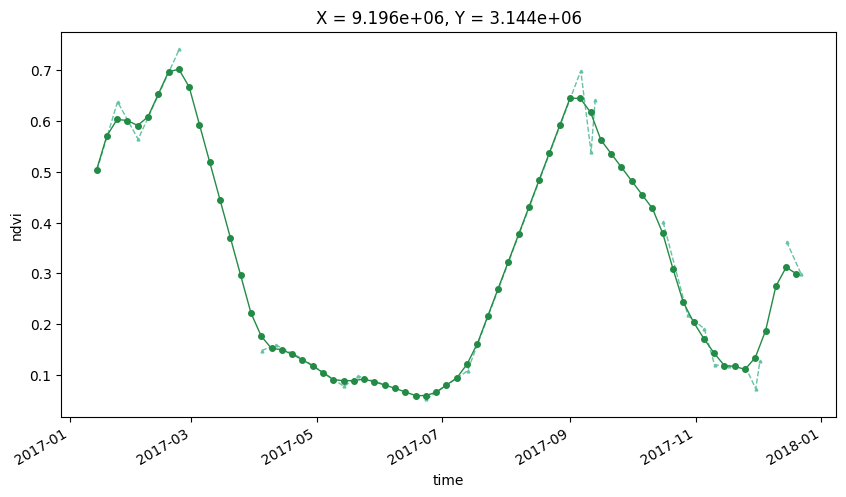

In [44]:
#Plot the original and smoothed time-series.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
original_time_series.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
time_series_smooth.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
plt.show()


In [45]:
#Convert the DataArray to a Pandas DataFrame and save it as a CSV file.
df = time_series_smooth.to_dataframe('ndvi').reset_index()
df
output_filename = 'smoothed_time_series.csv'
df[['time', 'ndvi']].to_csv(output_filename, index=False)
